<a href="https://colab.research.google.com/github/andreregino/tutorial-2-kg-with-llm/blob/main/Tutorial_2_KG_Generation_with_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geração de Triplas com LLMs

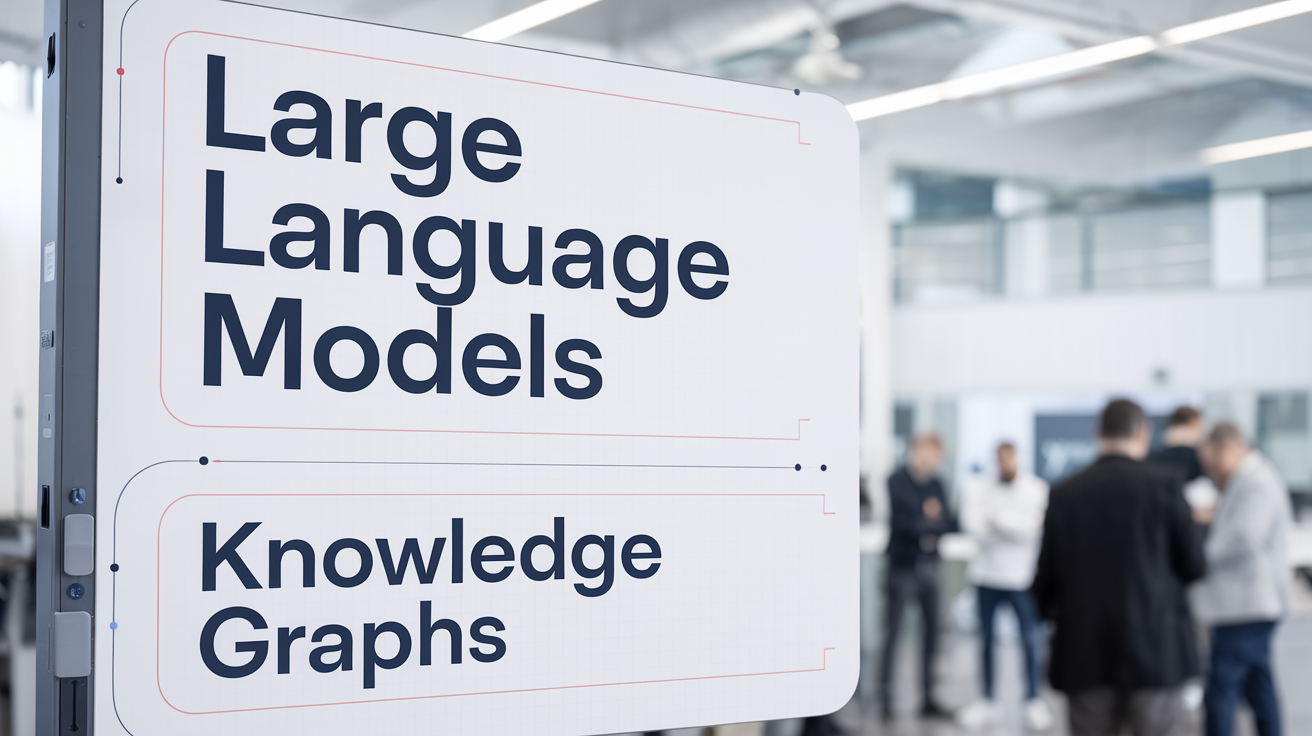

## 1) Introdução

Neste tutorial, você aprenderá a gerar triplas RDF utilizando modelos de linguagem (LLMs). O foco será na criação de triplas que sejam consistentes e possam ser integradas a um grafo de conhecimento existente ou novo.


Usaremos as seguintes ferramentas e bibliotecas:


*   Groq - Provedor de LLMs
*   Llama
* RDF Grapher
* RDF Visualizer
* Pandas

## 2) Configuração do Ambiente

### 2.1) Instalação de Bibliotecas

Execute o seguinte código para instalar as bibliotecas necessárias:

In [ ]:
!pip install -q groq pandas rdflib ontospy pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s eta 0:00:00


### 2.2) Imports Necessários

Após instalar as bibliotecas, importe os pacotes necessários:

In [ ]:
import groq
import pandas as pd
from rdflib import Graph, Literal, RDF, URIRef
from rdflib.namespace import FOAF, XSD
from google.colab import userdata # para usar o Secrets do Google Colab
import ontospy
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from groq import Groq
import requests
import random

### 2.3) Geração e Configuração da Chave de Acesso do Groq

add explicacao do que é chave api groq
add explicacao sobre os modelos
add explicacao de como adicionar nos secrets
add explicacao sobre como adicionar no código a chave

In [ ]:
GROQ_TOKEN = userdata.get('GROQ_TOKEN') # adicione sua chave aqui

### 2.4) Consultando os Modelos Disponíveis no Groq

In [18]:
url = "https://api.groq.com/openai/v1/models"

headers = {
    "Authorization": f"Bearer {GROQ_TOKEN}",
    "Content-Type": "application/json"
}

response = requests.get(url, headers=headers)

for models in response.json()["data"]:
  print("Modelo:", models["id"], "com tamanho de contexto", models["context_window"], "tokens")

Modelo: llama3-8b-8192 com tamanho de contexto 8192 tokens
Modelo: llama3-groq-70b-8192-tool-use-preview com tamanho de contexto 8192 tokens
Modelo: gemma-7b-it com tamanho de contexto 8192 tokens
Modelo: gemma2-9b-it com tamanho de contexto 8192 tokens
Modelo: llama3-70b-8192 com tamanho de contexto 8192 tokens
Modelo: mixtral-8x7b-32768 com tamanho de contexto 32768 tokens
Modelo: distil-whisper-large-v3-en com tamanho de contexto 448 tokens
Modelo: whisper-large-v3 com tamanho de contexto 448 tokens
Modelo: llama-3.1-70b-versatile com tamanho de contexto 131072 tokens
Modelo: llama-3.1-8b-instant com tamanho de contexto 131072 tokens
Modelo: llama3-groq-8b-8192-tool-use-preview com tamanho de contexto 8192 tokens
Modelo: llama-guard-3-8b com tamanho de contexto 8192 tokens


## 3) Exemplo 1: Atualizando um Grafo de Conhecimento de Produtos

add imagem relativa ao assunto

### 3.1) Criação de um Grafo de Conhecimento Inicial

primeiro, criamos um "dataset" sintético, contendo algumas informações sobre produtos eletrônicos vendidos em um e-commerce
visualizamos ele em um pandas dataframe, uma estrutura que ajuda na visualização de dados tabulares


In [ ]:
data = {
    "produto": ["Notebook LG i7", "Smartphone Samsung s20 FE", "Tablet iPad"],
    "categoria": ["Eletrônicos", "Eletrônicos", "Eletrônicos"],
    "descricao": [
        "Notebook com 8GB de RAM e 256GB de SSD.",
        "Smartphone com câmera de 12MP e 64GB de armazenamento.",
        "Tablet com tela de 10 polegadas e 128GB de armazenamento."
    ]
}

df = pd.DataFrame(data)
df.head()

,produto,categoria,descricao
0,Notebook LG i7,Eletrônicos,Notebook com 8GB de RAM e 256GB de SSD.
1,Smartphone Samsung s20 FE,Eletrônicos,Smartphone com câmera de 12MP e 64GB de armaze...
2,Tablet iPad,Eletrônicos,Tablet com tela de 10 polegadas e 128GB de arm...


In [ ]:
from rdflib import Graph, Literal, RDF, URIRef
from rdflib.namespace import FOAF, XSD, DCTERMS

# Definindo o gráfico
g = Graph()

# Definindo namespaces
n = URIRef("http://example.org/product/")

# Adicionando triplas ao gráfico
for index, row in df.iterrows():
    produto = URIRef(n + row["produto"].replace(" ", "_"))
    g.add((produto, RDF.type, FOAF.Document))
    g.add((produto, FOAF.name, Literal(row["produto"], datatype=XSD.string)))
    g.add((produto, FOAF.topic, Literal(row["categoria"], datatype=XSD.string)))  # Alterado para 'topic'
    g.add((produto, DCTERMS.description, Literal(row["descricao"], datatype=XSD.string)))  # Usando 'description' de DCTERMS

# Serializando o gráfico em formato Turtle
print(g.serialize(format="turtle"))


@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://example.org/product/Notebook_LG_i7> a foaf:Document ;
    dcterms:description "Notebook com 8GB de RAM e 256GB de SSD."^^xsd:string ;
    foaf:name "Notebook LG i7"^^xsd:string ;
    foaf:topic "Eletrônicos"^^xsd:string .

<http://example.org/product/Smartphone_Samsung_s20_FE> a foaf:Document ;
    dcterms:description "Smartphone com câmera de 12MP e 64GB de armazenamento."^^xsd:string ;
    foaf:name "Smartphone Samsung s20 FE"^^xsd:string ;
    foaf:topic "Eletrônicos"^^xsd:string .

<http://example.org/product/Tablet_iPad> a foaf:Document ;
    dcterms:description "Tablet com tela de 10 polegadas e 128GB de armazenamento."^^xsd:string ;
    foaf:name "Tablet iPad"^^xsd:string ;
    foaf:topic "Eletrônicos"^^xsd:string .




### 3.2) Visualização do Grafo de Conhecimento Inicial

In [ ]:
for s, p, o in g:
  print(s, p, o)

http://example.org/product/Notebook_LG_i7 http://purl.org/dc/terms/description Notebook com 8GB de RAM e 256GB de SSD.
http://example.org/product/Notebook_LG_i7 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://xmlns.com/foaf/0.1/Document
http://example.org/product/Tablet_iPad http://xmlns.com/foaf/0.1/topic Eletrônicos
http://example.org/product/Smartphone_Samsung_s20_FE http://xmlns.com/foaf/0.1/name Smartphone Samsung s20 FE
http://example.org/product/Notebook_LG_i7 http://xmlns.com/foaf/0.1/name Notebook LG i7
http://example.org/product/Smartphone_Samsung_s20_FE http://xmlns.com/foaf/0.1/topic Eletrônicos
http://example.org/product/Smartphone_Samsung_s20_FE http://purl.org/dc/terms/description Smartphone com câmera de 12MP e 64GB de armazenamento.
http://example.org/product/Tablet_iPad http://purl.org/dc/terms/description Tablet com tela de 10 polegadas e 128GB de armazenamento.
http://example.org/product/Tablet_iPad http://xmlns.com/foaf/0.1/name Tablet iPad
http://example.or

Gerados por [RDF Grapher](https://www.ldf.fi/service/rdf-grapher) e [RDF Visualizer](https://issemantic.net/rdf-visualizer)

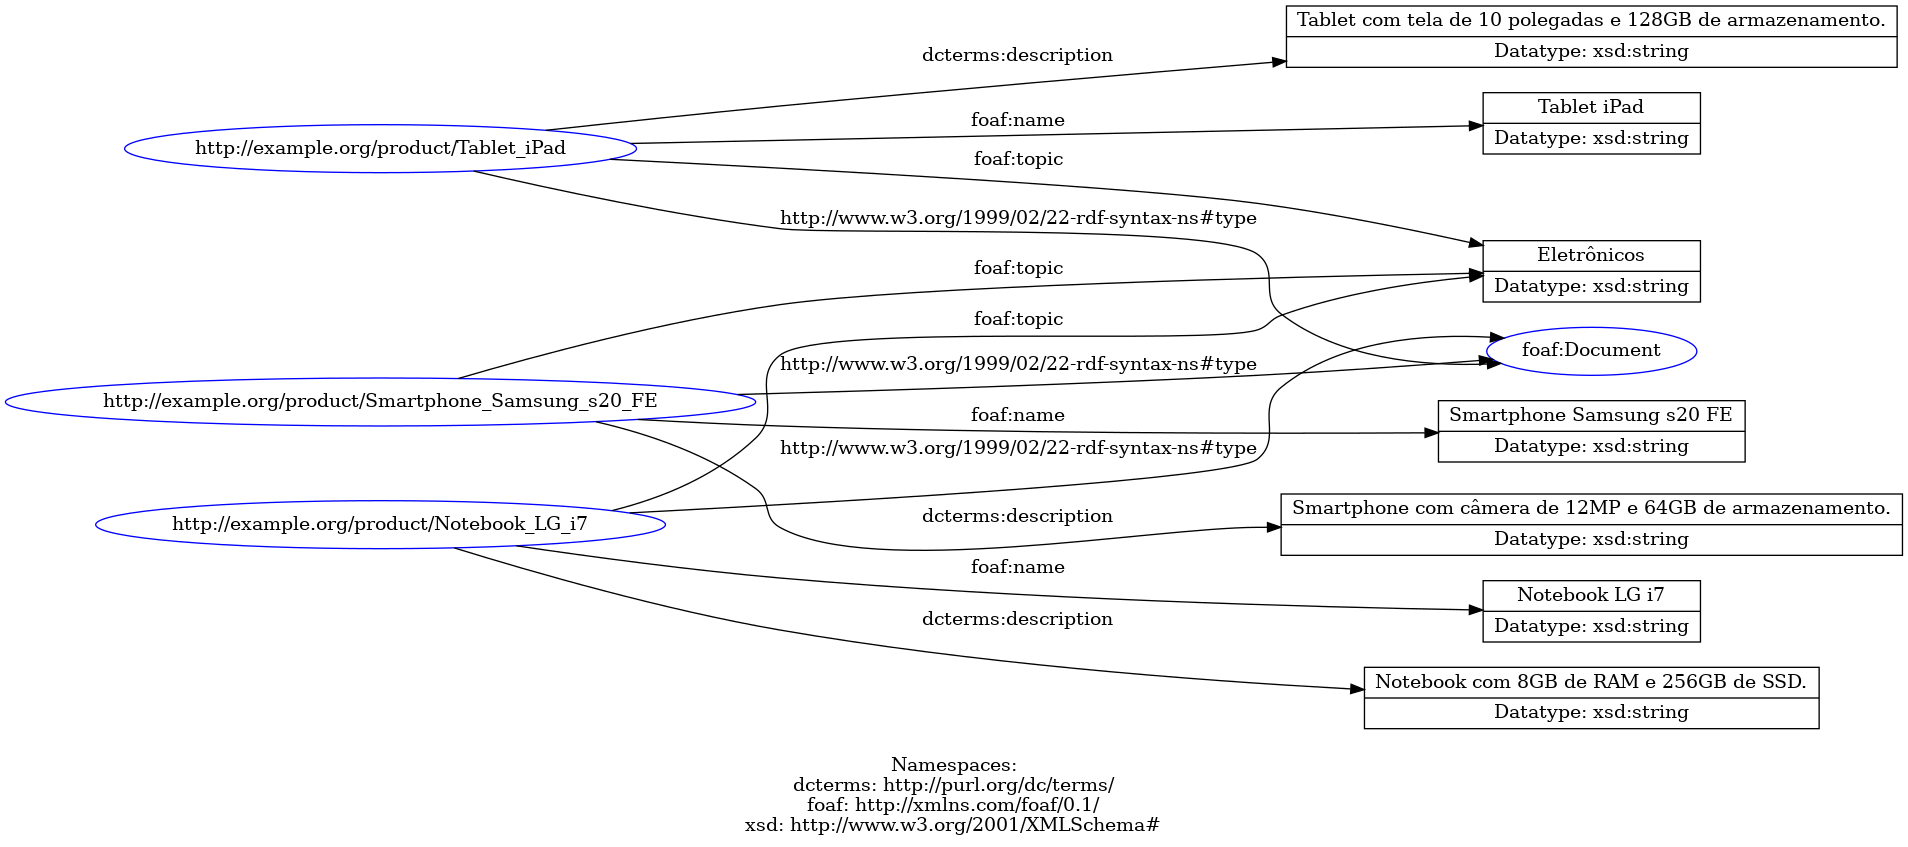

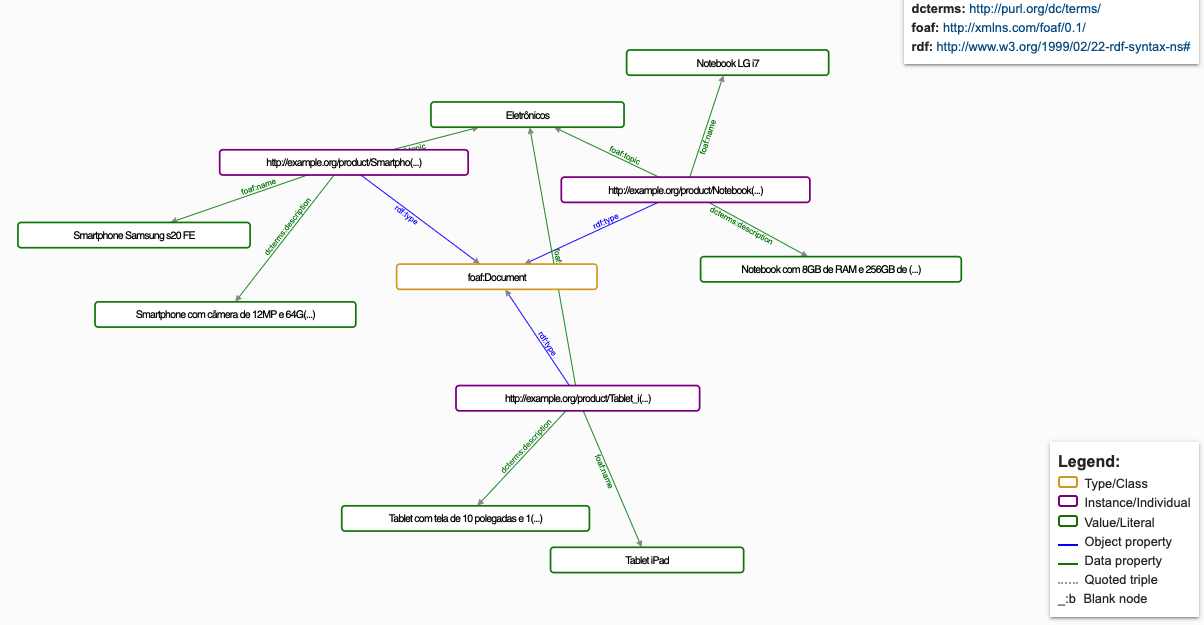

### 3.3) Atualizando o Grafo de Conhecimento com Novas Triplas

In [ ]:
dataset_inicial = [
    "Ração Whiskas para gato, 2 kg",
    "Par de retrovisores Metagal preto metálico para Honda Fit 2022",
    "Camiseta Bob Esponja tamanho M azul"
]


#### 3.3.1) Prompt

In [ ]:
def prompt_direcoes_exemplo_1():
  return "You will receive a sentence. Your task is to create RDF triples based on that sentence. \n \
  Only return the RDF triples. Avoid explanation. \
  I will provide two examples. Complete the third. \n \
  \Sentence: Notebook LG i7 com 8GB de RAM e 256GB de SSD. \n\
  \RDF Triples: <http://example.org/product/Notebook_LG_i7> a foaf:Document . \
     <http://example.org/product/Notebook_LG_i7> dcterms:description 'Notebook com 8GB de RAM e 256GB de SSD.'^^xsd:string . \
     <http://example.org/product/Notebook_LG_i7>  foaf:name 'Notebook LG i7'^^xsd:string . \
    <http://example.org/product/Notebook_LG_i7> foaf:topic 'Eletrônicos'^^xsd:string . \
  \n\n\n \
  \
  Sentence: Tablet iPad	Eletrônicos	Tablet com tela de 10 polegadas e 128GB de armazenamento. \n\
  RDF Triples: <http://example.org/product/Tablet_iPad> a foaf:Document . \
    <http://example.org/product/Tablet_iPad> dcterms:description 'Tablet com tela de 10 polegadas e 128GB de armazenamento.'^^xsd:string . \
    <http://example.org/product/Tablet_iPad> foaf:name 'Tablet iPad'^^xsd:string . \
    <http://example.org/product/Tablet_iPad> foaf:topic 'Eletrônicos'^^xsd:string . \
    \n\n\n"

def prompt_final(frase):
  new_prompt = prompt_direcoes_exemplo_1()
  new_prompt += "\nSentence: " + frase
  new_prompt += "\nRDF Triples: "
  return new_prompt


### 3.3.2) Conexão com o Groq

In [ ]:
def query_to_model_groq(model_name, content):
  client = Groq(
      api_key=GROQ_TOKEN,
  )

  chat_completion = client.chat.completions.create(
      messages=[
          {
              "role": "user",
              "content": content,
          }
      ],
      model=model_name,
  )

  return chat_completion.choices[0].message.content

query_to_model_groq("llama3-70b-8192", "What is the biggest Brazilian city?")

"The biggest Brazilian city is São Paulo. It is the capital of the state of São Paulo and is located in the southeastern part of the country. As of 2021, the city has a population of over 22 million people, making it not only the largest city in Brazil but also one of the largest cities in the world.\n\nSão Paulo is a major cultural, economic, and financial hub in Brazil, and it's known for its diverse cultural scene, rich history, and vibrant nightlife. The city is also an important center for business and industry, and it's home to many multinational companies and startups.\n\nThe metropolitan area of São Paulo, which includes several surrounding cities, has a population of over 32 million people, making it the largest metropolitan area in the Americas and one of the largest in the world."

### 3.3.3) Gerando as Novas Triplas

In [ ]:
# querying the model and generating the summarized sentence

triples_to_be_added = []
for frase in dataset_inicial:
    prompt = prompt_final(frase)
    #print(prompt)
    answer = query_to_model_groq("llama3-70b-8192", prompt)

    triples_to_be_added.append(answer)
    print(f"\n\nFrase: {frase}\nTriplas: {answer}")

#triples_to_be_added #saving in a list of summarized sentences



Frase: Ração Whiskas para gato, 2 kg
Triplas: <http://example.org/product/Ração_Whiskas_para_gato_2kg> a foaf:Document .
<http://example.org/product/Ração_Whiskas_para_gato_2kg> dcterms:description 'Ração para gato, 2 kg.'^^xsd:string .
<http://example.org/product/Ração_Whiskas_para_gato_2kg> foaf:name 'Ração Whiskas para gato, 2 kg'^^xsd:string .
<http://example.org/product/Ração_Whiskas_para_gato_2kg> foaf:topic 'Alimentos para animais'^^xsd:string .


Frase: Par de retrovisores Metagal preto metálico para Honda Fit 2022
Triplas: <http://example.org/product/Par_de_retrovisores_Metagal_preto_metálico_para_Honda_Fit_2022> a foaf:Document .
<http://example.org/product/Par_de_retrovisores_Metagal_preto_metálico_para_Honda_Fit_2022> dcterms:description 'Par de retrovisores metálico preto para Honda Fit 2022.'^^xsd:string .
<http://example.org/product/Par_de_retrovisores_Metagal_preto_metálico_para_Honda_Fit_2022> foaf:name 'Par de retrovisores Metagal preto metálico para Honda Fit 2022'

## 4) Exemplo 2: Criando Triplas de Perguntas e Respostas de Comércio Eletrônico

### 4.1) Criação das Perguntas e Respostas

In [ ]:
# Function to generate a random product ID
def generate_product_id():
    return f"PROD{random.randint(1000, 9999)}"

# Function to generate compatibility questions and answers
def generate_compatibility_data():
    questions = [
        "Is the product compatible with the Honda Civic 2012/2013?",
        "Does the product fit the Tesla 2019?",
        "Is the product suitable for the Audi TT 2013?",
        "Is it compatible with my 2020 Ford Focus?",
        "If I buy it, is it gonna fit my 1987 Chevrolet Impala"
    ]
    answers = [
        "Yes",
        "No",
        "You can buy it, it fits",
        "No, unfortunately it does not fit"
    ]

    product_id = generate_product_id()
    question = random.choice(questions)
    answer = random.choice(answers)
    return {"product_id": product_id, "question": question, "answer": answer}

# Generate 10 rows of dataset
data = []
for _ in range(10):
    compatibility_data = generate_compatibility_data()
    data.append(compatibility_data)

df = pd.DataFrame(data)
df.head()

,product_id,question,answer
0,PROD4745,Does the product fit the Tesla 2019?,"No, unfortunately it does not fit"
1,PROD2761,Is the product compatible with the Honda Civic...,No
2,PROD9590,"If I buy it, is it gonna fit my 1987 Chevrolet...","No, unfortunately it does not fit"
3,PROD4813,Is the product compatible with the Honda Civic...,Yes
4,PROD1107,"If I buy it, is it gonna fit my 1987 Chevrolet...","No, unfortunately it does not fit"


### 4.2) Sumarização

In [ ]:
initial_directions = '''For each example below, you should summarize if there is a compatibility between the mentioned car in the question and the customer product in the Summarized Compatibility field.
  To answer it, I will provide 3 fields: the product ID, the question containing the car and the answer stating if the product and the car are compatible.
  You should always answer using the product ID, the car name and the compatibility.
  Avoid using any car specification that are not in the question or in the answer.
  Avoid using any product specification that is not written in the question or answer.
  The answer should be placed after the string 'Summarized Compatibility:'.
  If the product and the car are not compatible, just answer that they are not compatible. Im going to provide you three examples.
  Complete the fourth.
  '''

few_shots_examples = '''
  Product ID: MB121391021 \
  Question: Hey buddy, does it fit for the hb20 2015 original radio?
  Answer: I hope you are okay! Yes, it fits, perfectly.
  Summarized Compatibility: The MB121391021 fits in hb20 2015
   ###
  Product ID: MLB134232121
  Question: Hi! Does it fit in 2003 Fiesta 2004 model?.
  Answer: Unfortunately this kit is not compatible with your car due to the frame not being compatible.
  Summarized Compatibility: The MLB134232121 is not compatible with Fiesta 2003/2004
  ###
  Product ID: MLB12718279
  Question: Does it work on Santana 99/2000 with power steering and air conditioning?
  Answer: Yes, it fits, perfectly.
  Summarized Compatibility: The MLB12718279 fits in santana 99/2000
  ###
  '''

def prompt_direcoes_sumarizacao_exemplo_2():
  return initial_directions + few_shots_examples

def prompt_final_sumarizacao_exemplo_2(fields):
  new_prompt = prompt_direcoes_sumarizacao_exemplo_2()
  new_prompt += "\nProduct ID: " + fields['product_id']
  new_prompt += "\nQuestion: " + fields['question']
  new_prompt += "\nAnswer: " + fields['answer']
  new_prompt += "\nSummarized Compatibility: "

  return new_prompt

In [ ]:
# querying the model and generating the summarized sentence

summarized_sentences = []
for coluna, linha in df.iterrows():
    #print(df[coluna])
    prompt = prompt_final_sumarizacao_exemplo_2(linha)
    summarized_sentence = query_to_model_groq("llama3-70b-8192", prompt)

    summarized_sentences.append(summarized_sentence)
    print(f"\n\nProduct ID: {linha['product_id']} Question: {linha['question']} Answer: {linha['answer']} \nSummarization: {summarized_sentence}")



Product ID: PROD4745 Question: Does the product fit the Tesla 2019? Answer: No, unfortunately it does not fit 
Summarization: The PROD4745 is not compatible with Tesla 2019


Product ID: PROD2761 Question: Is the product compatible with the Honda Civic 2012/2013? Answer: No 
Summarization: The PROD2761 is not compatible with Honda Civic 2012/2013


Product ID: PROD9590 Question: If I buy it, is it gonna fit my 1987 Chevrolet Impala Answer: No, unfortunately it does not fit 
Summarization: The PROD9590 is not compatible with Chevrolet Impala 1987


Product ID: PROD4813 Question: Is the product compatible with the Honda Civic 2012/2013? Answer: Yes 
Summarization: Summarized Compatibility: The PROD4813 fits in Honda Civic 2012/2013


Product ID: PROD1107 Question: If I buy it, is it gonna fit my 1987 Chevrolet Impala Answer: No, unfortunately it does not fit 
Summarization: Summarized Compatibility: The PROD1107 is not compatible with Chevrolet Impala 1987


Product ID: PROD9700 Questi

### 4.3) Geração das Triplas

In [ ]:
ontology_parts = {
    "Classes": ["Car", "Store", "Product", "Compatibility"],
    "Properties": ["rdf:type", "onto:Car", "onto:hasMLID", "onto:Product", "onto:FullCompatibility", "onto:ConditionalCompatibility", "onto:sells", "onto:NoCompatibility", "onto:compatibleWith", "onto:hasCompatibility", "onto:hasModel", "onto:hasModelYear", "onto:hasFabricationYear", "onto:hasBrand"]
}

In [ ]:
initial_directions = '''
  For each example below, you should create RDF triples that describe a summarized sentence.
  Im going to provide you the sentence and you create many triples based on the sentence.
  To help you, I will also provide the classes and properties that should be present in the generated RDF triples.
  These classes and properties are defined in an ontology.
  The sentence is composed by a product id (example: MLB12344567), a car owned by a customer (example: Tesla Model S) and a compatibility (example: fits, does not fit, not compatible, compatible).
  In the triples, each dot represent an end of a triple.
  Please generate RDF triples to describe the compatibility of a product with a car, adhering to the following classes and properties defined in the ontology:
  Classes: ''' + ", ".join(ontology_parts["Classes"]) + '''
  Properties:  ''' + ", ".join(ontology_parts["Properties"]) + '''
  Just use properties that are in the list. Never use other properties outside the list.
  Ignore new properties
  I will provide two examples. Complete the third.
  '''

few_shots_examples = '''
  Sentence: The MLB1148246525 fits in Ford Ka SE Plus At 2018/2019.
  Triples: <store/store_name> onto:sells <Product/store_name/ml-id-mlb1148246525> .
  <Car/ka-2018-2019> rdf:type Onto:Car . <Car/ka-2018-2019> onto:hasModel 'ka' . <Car/ka-2018-2019> onto:hasModelYear '2019'^^xsd:integer . <Car/ka-2018-2019> onto:hasFabricationYear '2018'^^xsd:integer . <Car/ka-2018-2019> onto:hasBrand 'ford' .
  <Product/store_name/ml-id-mlb1148246525> rdf:type onto:Product . <Product/store_name/ml-id-mlb1148246525> onto:hasMLID 'MLB1148246525' . <Product/store_name/ml-id-mlb1148246525> onto:hasCompatibility <FullCompatibility/store_name/ml-id-mlb1148246525/ka-2018-2019> .
  <FullCompatibility/store_name/ml-id-mlb1148246525/ka-2018-2019> onto:compatibleWith <Car/ka-2018-2019> . <FullCompatibility/store_name/ml-id-mlb1148246525/ka-2018-2019> rdf:type onto:FullCompatibility .
  ###
  Sentence: The MLB732402109 is not compatible with Gol 93 in the door.
  Triples: <Store/store_name> onto:sells <Product/store_name/ml-id-mlb732402109> .
  <Car/gol-1993> rdf:type onto:Car . <Car/gol-1993> onto:hasModel 'gol' . <Car/gol-1993> onto:hasModelYear '1993'^^xsd:integer .
  <Product/store_name/ml-id-mlb732402109> rdf:type onto:Product . <Product/store_name/ml-id-mlb732402109> onto:hasMLID 'MLB732402109' . <Product/store_name/ml-id-mlb732402109> onto:hasCompatibility <NoCompatibility/store_name/ml-id-mlb732402109/gol-1993> .
  <NoCompatibility/store_name/ml-id-mlb732402109/gol-1993> onto:compatibleWith <Car/gol-1993> . <NoCompatibility/store_name/ml-id-mlb732402109/gol-1993> rdf:type onto:NoCompatibility .
  ###
  '''

def prompt_direcoes_triplificacao_exemplo_2():
  return initial_directions + few_shots_examples


def prompt_final_triplificacao_exemplo_2(fields):
  new_prompt = prompt_direcoes_triplificacao_exemplo_2()
  new_prompt += "\nSentence: " + fields
  new_prompt += "\nTriples: "

  return new_prompt

In [ ]:
# querying the model and generating the summarized sentence

generated_triples = []
for linha in summarized_sentences:
    prompt = prompt_final_triplificacao_exemplo_2(linha)
    triple = query_to_model_groq("llama3-70b-8192", prompt)

    generated_triples.append(triple)
    print(f"\n\nSentence: {linha} \nTriples: {triple}")



Sentence: The PROD4745 is not compatible with Tesla 2019 
Triples: Here are the generated RDF triples:

<Store/store_name> onto:sells <Product/store_name/ml-id-prod4745> .
<Car/tesla-2019> rdf:type onto:Car . <Car/tesla-2019> onto:hasModel 'tesla' . <Car/tesla-2019> onto:hasModelYear '2019'^^xsd:integer .
<Product/store_name/ml-id-prod4745> rdf:type onto:Product . <Product/store_name/ml-id-prod4745> onto:hasMLID 'PROD4745' . <Product/store_name/ml-id-prod4745> onto:hasCompatibility <NoCompatibility/store_name/ml-id-prod4745/tesla-2019> .
<NoCompatibility/store_name/ml-id-prod4745/tesla-2019> onto:compatibleWith <Car/tesla-2019> . <NoCompatibility/store_name/ml-id-prod4745/tesla-2019> rdf:type onto:NoCompatibility .


Sentence: The PROD2761 is not compatible with Honda Civic 2012/2013 
Triples: Here are the RDF triples based on the sentence:

### Triples:

<Store/store_name> onto:sells <Product/store_name/ml-id-prod2761> .
<Car/civic-2012-2013> rdf:type onto:Car . <Car/civic-2012-2013

## 5) Desafio